# Import Package

In [1]:
import gym
from gym import envs
from gym import wrappers, logger
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from PIL import Image
from tqdm import tqdm
from pathlib import Path, PureWindowsPath
import torch
from collections import deque
from ddpgagent import Agent3
import numpy as np
from utility import Config_DDPG

################################## set device ##################################
print("============================================================================================")
# set device to cpu or cuda
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    device = torch.device('cpu')
    print("Device set to : cpu")
print("============================================================================================")


c:\Users\lynch\anaconda3\envs\DQN_win\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create the storage folder and generate log file 
## Folder route
* The folder is saved under the route describes in the cell, (mainly 'document/model/``file_name``')
* The ``file_name`` is the name of storag folder for current training.



## Set reward function configuration car racing environment
1. In the car racing environment, the [car_racing.py](gym/envs/box2d/car_racing.py) contains the reward function configuration where user can play around for designing the risk awareness that the agent targeted to learn.
2. Can modify the configuration of parameters before training, the log files are collected under the same directory.
   * The configuration file defines the training episodes, frequency of saving learned model in `*.pth` files for both actor and critic networks.


In [2]:
# create folder
file_name = 'DDPG_reshape' # Folder name
p_model = (Path()/ 'document'/'model'/file_name) # storage under model directory
p_model.mkdir(parents=True, exist_ok=True) # create if no directory existed

# CUDA
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Now using device with cuda:',device,'.\n')  

# Track
# load_tracks_from=TRACK -- Load a specific map from a pkl file
TRACK = 'track'

# ENV
# Gym make the environment
frame = int(1) # state is frame - 1
env = gym.make('CarRacing-v0', num_obstacles=100, show_info_panel=1,
               num_tracks=1, num_lanes=1, discretize_actions='soft', 
               allow_outside=False, grayscale=1, frames_per_state=frame,load_tracks_from = TRACK)
action_size = env.action_space.n
observation_space = env.observation_space.shape

# Parameters
""" configuration of parameter setup, and setup training configuration. """
# modify under
Episode_train = 5           # Total training episodes
Model_Save_frequency = 2    # the frequency of saving model under directory
Time_stamp = 500            # Exploring time stamps
seed = 32
cfg = Config_DDPG(Episode=int(Episode_train), max_ep_len=Time_stamp,random_seed=int(seed),freq_save_epi=int(Model_Save_frequency))
setattr(cfg, 'state_size', observation_space) # create the state size parameter
setattr(cfg, 'action_size', action_size)      # create the action size parameter

# generate an agent
agent = Agent3(cfg)

if p_model.is_dir():
    nb_name = 'log_par.txt'
    with open(p_model.joinpath(nb_name), "w") as f:
        f.write('-----------------------Var Config-----------------------\n')
        for key, value in vars(cfg).items(): 
            f.write('%s:%s\n' % (key, value))
        f.write('-----------------------Var Env-----------------------\n')
        for key, value in vars(env).items():
            f.write('%s:%s\n' % (key, value))
        f.write('-----------------------Var File-----------------------\n')
        f.write('Directroy: %s,\n'% p_model)
        f.write('SOFT_NEG_REWARD = 0.1, \nOut side: -100, \n reward += (((left | right) & not_visited).sum()/ factor),\n')
        print('Log File was created.')
        f.close()
else:
    print("Directory doesn\'t exist.")

Now using device with cuda: cuda .

Log File was created.


# Training function for DDPG

In [3]:
from utility import score_save

def ddpg(n_episodes=5, max_t=cfg.max_ep_len,save_path=Path):
    '''
    # DDPG training function.    
    ## input     
    * `n_episodes = int(cfg.Episode)` # training episodes
    * `max_t = cfg.max_ep_len` # time stamp
    * `save_folder = p_model # assigned when create folder route`    
    ## output
    (scores,avg_scores), agent
    '''
    scores_deque = deque(maxlen=100) # take the last 100 scores and average
    scores = []
    avg_scores = []
    max_score = -np.Inf
    n_episodes = n_episodes
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        avg_scores.append(np.mean(scores_deque))
        if i_episode % cfg.freq_save_epi == 0: # frequency of saving agent model file and scores. default=500
            actor_name = f'DDPG_actor{i_episode}.pth'
            critic_name = f'DDPG_critic{i_episode}.pth'
            torch.save(agent.actor_local.state_dict(), (save_path/actor_name))
            torch.save(agent.critic_local.state_dict(), (save_path/critic_name))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            file_name = f"DDPG_soft_default_{i_episode}"
            print('\n',save_path)
            score_save(scores, averagescore=avg_scores, file_name=file_name, path=save_path, print_=False)
    return scores,avg_scores, agent


## Start training

The following cell start training for the agent.

* Total training time are logged as `Run_log_training.txt` and will storage under the same directory.
* The learned models are storaged as the frequency of storaging episodes as setted up above. (default is `every 2 episode save model once.`)
* Plot for average scores and all scores are illustrated.
  * The score plot shows the score of the end result of single episode.
  * The average plot shows the averaging of last 100 time stamps' scoring. (in one episode)
    > Since the agent can result in a lower score, for instance, by hitting on the obstacle after exploring for a while on the track. Collision does not represent the total actions what the agent already done.

* The csv storages the score and average scores are under the same directory.


  

In [ ]:
import time
# Training start
start = time.time()
scores,avg_scores, agent = ddpg(n_episodes=cfg.Episode, max_t= cfg.max_ep_len, save_path=p_model)
end = time.time()
# Training end
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


# Plot training results

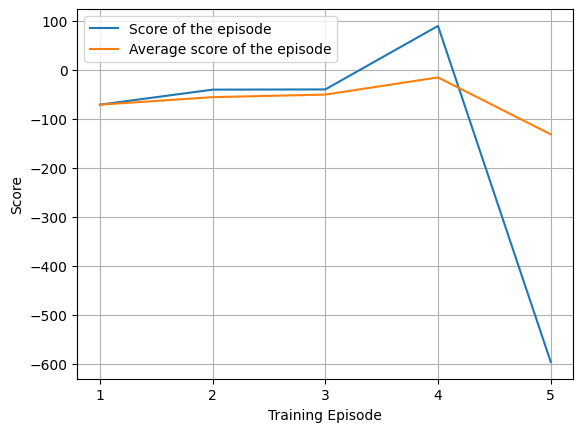

In [5]:
Episode = cfg.Episode
image_name = f'DDPG_{Episode}.png'
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score of the episode")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Average score of the episode")
plt.legend()
plt.ylabel('Score')
plt.xlabel(f'Training Episode')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.savefig((p_model/image_name))
plt.grid()
plt.show()

if p_model.is_dir():
    nb_name = 'Run_log_training.txt'
    with open(p_model.joinpath(nb_name), "w") as f:
        f.write("Total training time: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
        f.write('Toal epoch:%s\n'%Episode)
        f.write('Csv file name:%s\n'%file_name)
        f.close()